In [38]:
# https://openrouteservice.org/
# https://openrouteservice.org/dev/#/api-docs/v2/directions/{profile}/get

# username = dconly
# email = dconly@sacog.org

import requests
import os

import geopandas as gpd

api_key_source = r"C:\Users\dconly\GitRepos\GIS-tools\ORS\api2_DO_NOT_COMMIT.txt"
with open(api_key_source) as f:
    ors_api_key = f.readline()


In [41]:
# load the project line into geodataframe; assumes the line is loaded from a projection that uses feet units
fgdb = r'I:\Projects\Darren\PEP\PEP_GIS\PEP_GIS.gdb'
lyr = 'test_sr51'

gdf_line = gpd.GeoDataFrame.from_file(fgdb, layer=lyr, driver="OpenFileGDB")
# gdf_line = gdf_line.to_crs("EPSG:4326")

In [73]:
# make evenly-spaced points along the line
import numpy as np
crs_wgs84 = "EPSG:4326"

gs_line = gdf_line.geometry

line_len = gs_line.length[0]
seg_dist = 1000 # how many feet you want the points spaced apart

distances = [i for i in np.arange(0,line_len, seg_dist)]
if line_len not in distances:
             distances.append(line_len)
             
seg_points = [gs_line.interpolate(dist).to_crs(crs_wgs84) for dist in distances]
seg_points_xy = [(p.x[0], p.y[0]) for p in seg_points]
seg_points_batched = [seg_points_xy[i:i + 5] for i, v in enumerate(seg_points_xy) if i % 5 == 0]
seg_points_batched


[[(-121.46469055459444, 38.57988401852383),
  (-121.45861800965129, 38.584699744179005),
  (-121.44976960433576, 38.58575489858421),
  (-121.44553909513247, 38.591598369742826),
  (-121.44369337805918, 38.596887833434906)]]

In [74]:
# generate isochrones around each of those points
max_time_mins = 15
max_time_sec = max_time_mins * 60
travel_mode = "driving-car" # "driving-car" #"foot-walking"

gdf_master = gpd.GeoDataFrame()

# Go through each batch of 5 points and draw an isochrone around them, then combine all the batches together
# into 1 geodatframe with all relevant isochrone polygons in it. Next step would then be dissolve all polygons.
for pts_batch in seg_points_batched:

    body = {"locations":pts_batch, "range":[max_time_sec], "range_type":"time"}

    headers = {
        'Accept': 'application/json, application/geo+json, application/gpx+xml, img/png; charset=utf-8',
        'Authorization': ors_api_key,
        'Content-Type': 'application/json; charset=utf-8'
    }

    call = requests.post(f'https://api.openrouteservice.org/v2/isochrones/{travel_mode}', json=body, headers=headers)

    polygon_txt = call.text
    gdf_batch = gpd.read_file(polygon_txt)
    gdf_batch['dissolve_col'] = 0
    gdf_master = gdf_master.append(gdf_batch)
    
gdf_master.head(14)
gdf_master.plot(cmap='Set1')



,group_index,value,geometry,dissolve_col
0,0,900.0,"POLYGON ((-121.71354 38.55061, -121.71274 38.5...",0
1,1,900.0,"POLYGON ((-121.70544 38.55245, -121.70465 38.5...",0
2,2,900.0,"POLYGON ((-121.69837 38.55395, -121.69787 38.5...",0
3,3,900.0,"POLYGON ((-121.68922 38.55614, -121.68842 38.5...",0
4,4,900.0,"POLYGON ((-121.68331 38.55747, -121.68254 38.5...",0


<AxesSubplot:>

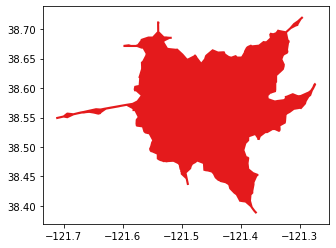

In [77]:
# Dissolve the multiple polygons into single polygon using Geopandas
gdfd = gdf_master.dissolve(by='dissolve_col')

gdfd.plot(cmap='Set1')

In [40]:
# Make isochrone around single point (NOT necessary to run for making line-based isochrone)
# https://openrouteservice.org/dev/#/api-docs/isochrones

travel_mode = "foot-walking"

orgn_lat = 38.59312635026946
orgn_lon = -121.4487934112549

max_time_mins = 15
max_time_sec = max_time_mins * 60


# IMPORTANT NOTE!!! CAN ENTER ARRAY OF MULTIPLE LAT/LONGS, SO COULD INSERT MULTIPLE POINTS TO GET LINE-BASED ISOCHRONE
body = {"locations":[[orgn_lon, orgn_lat]], "range":[max_time_sec], "range_type":"time"}

headers = {
    'Accept': 'application/json, application/geo+json, application/gpx+xml, img/png; charset=utf-8',
    'Authorization': ors_api_key,
    'Content-Type': 'application/json; charset=utf-8'
}

call = requests.post(f'https://api.openrouteservice.org/v2/isochrones/{travel_mode}', json=body, headers=headers)

polygon_txt = call.text
polygon_txt

'{"type":"FeatureCollection","bbox":[-121.460692,38.58504,-121.437824,38.597321],"features":[{"type":"Feature","properties":{"group_index":0,"value":900.0,"center":[-121.44875188166795,38.593163819244374]},"geometry":{"coordinates":[[[-121.460692,38.595053],[-121.460571,38.594714],[-121.458764,38.590803],[-121.456705,38.590897],[-121.456491,38.5909],[-121.456302,38.590903],[-121.456132,38.590931],[-121.455065,38.591077],[-121.449436,38.591245],[-121.443846,38.589243],[-121.443085,38.588727],[-121.439565,38.585075],[-121.439041,38.58504],[-121.437897,38.58541],[-121.437824,38.585763],[-121.43858,38.587357],[-121.4389,38.587523],[-121.44245,38.588715],[-121.444365,38.59378],[-121.444745,38.595547],[-121.446982,38.597129],[-121.447307,38.597283],[-121.447612,38.597321],[-121.452781,38.596452],[-121.45395,38.596473],[-121.454629,38.596475],[-121.455329,38.596475],[-121.455981,38.5964],[-121.456653,38.596321],[-121.45696,38.596252],[-121.457279,38.59618],[-121.457952,38.595983],[-121.458635